<a href="https://colab.research.google.com/github/robfonti/Deep-Learning/blob/Projects/Computer_Vision_2_Dogs%26Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying Dogs and Cats with a Convolutional Neural Network

Images are medium-resolution color jpegs of dogs and cats.

In [2]:
import os,shutil
import pandas as pd
from google.colab import drive

Working in the cloud, so I have to mount my google drive to access the data set.

In [ ]:
drive.mount('/content/drive')

Next couple of cells are just geared towards taking the data and putting it in the right locations.  We'll need a parent training folder with separate directories for training_dogs,training_cats. Same thing for the validation data.

In [6]:
#dataset_directory = 'drive/My Drive/Colab Notebooks/Dogs&Cats/dataset'
dataset_directory = 'drive/My Drive/Colab Notebooks/Dogs&Cats2/dogs-vs-cats-unzipped'
print(os.getcwd())
os.chdir(dataset_directory)
os.mkdir('training')
os.chdir('training')
os.mkdir('train_dogs')
os.mkdir('train_cats')


/content


In [ ]:
#os.chdir('dogs-vs-cats-unzipped')

# Move 1000 dog images to training/train_dogs
# Move 1000 cat images to training/train_cats

training_path = 'train'

fnames = ['cat.{}.jpg'.format(i) for i in range(1,1000)]

# Cats
for fname in fnames:
  source = os.path.join(training_path,fname)
  dest = os.path.join('training','train_cats')
  shutil.move(source,dest)

In [13]:
# Dogs

fnames = ['dog.{}.jpg'.format(i) for i in range(1,1000)]

for fname in fnames:
  source = os.path.join(training_path,fname)
  dest = os.path.join('training','train_dogs')
  shutil.move(source,dest)

# Validation set for dogs
fnames = ['dog.{}.jpg'.format(i) for i in range(1001,1501)]
for fname in fnames:
  source = os.path.join(training_path,fname)
  dest = os.path.join('Validation','val_dogs')
  shutil.move(source,dest)

# Validation set for cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1001,1501)]
for fname in fnames:
  source = os.path.join(training_path,fname)
  dest = os.path.join('Validation','val_cats')
  shutil.move(source,dest)

Now lets layout out our network

In [4]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3))) #150 pixels*150 pixels*3 channels. Layer will look for 32 features in 3x3 windows
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten()) # To transform into vector data that we can feed into a dense network
model.add(layers.Dense(units=512,activation='relu'))
model.add(layers.Dense(units=1,activation='sigmoid')) # Just one unit needed to represent prob of dog

# Choose an optimizer, loss, and metrics
model.compile(optimizer= optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])


Lets check out our feature map and its dimensions change throughout the network

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [7]:
os.chdir('drive/My Drive/Colab Notebooks/Dogs&Cats2/dogs-vs-cats-unzipped')


We know that data should be formatted into preprocessed floating point tensors before being fed into a network.  Currently, the data is all in the form of JPEG files... so in order to use it in the network we need to
1.) Read the picture files
2.) Decode the JPEG into RGB grids of pixels
3.) Convert these into floating point tensors
4.) Rescale the pixel values (between 0 and 255) to between [0,1]..neural networks prefer to deal with small input values.

Keras has a module with image processing helper tools to handle things like this. *ImageDataGenerator* can automatically turn image files into batches of preprocessed tensors.  That is what we will use here.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

print(os.getcwd())

train_directory = 'training'
validation_directory = 'Validation'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size = (150,150), # Resizes all images to 150x150
    batch_size=20,
    class_mode='binary') # One folder for cats, one folder for dogs.

    
validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')



/content/drive/My Drive/Colab Notebooks/Dogs&Cats2/dogs-vs-cats-unzipped
Found 1998 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
?ImageDataGenerator

Lets look at the output of these generators... should be batches of 20 (150,150,3) tensors.

This also generates labels for us.  This is one of the reasons that we need to make sure that dogs and cats are in different folders in the training set, and the validation set contains 2 folders for dogs and cats as well.

In [35]:
for data_batch,labels_batch in validation_generator:
  print('data batch shape:',data_batch.shape)
  print('labels batch shape:',labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 616s 6s/step - loss: 0.7081 - accuracy: 0.4959 - val_loss: 0.6759 - val_accuracy: 0.5410
Epoch 2/30
100/100 [==============================] - 12s 118ms/step - loss: 0.6689 - accuracy: 0.5927 - val_loss: 0.6474 - val_accuracy: 0.6300
Epoch 3/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6331 - accuracy: 0.6404 - val_loss: 0.6107 - val_accuracy: 0.6660
Epoch 4/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5676 - accuracy: 0.7063 - val_loss: 0.5863 - val_accuracy: 0.6890
Epoch 5/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5287 - accuracy: 0.7323 - val_loss: 0.5844 - val_accuracy: 0.6850
Epoch 6/30
100/100 [==============================] - 12s 117ms/step - loss: 0.5043 - accuracy: 0.7459 - val_loss: 0.5884 - val_accuracy: 0.6870
Epoch 7/30
100/100 [==============================] - 12s 116ms/step - loss: 0.4863 - accuracy: 0.7625 - val_loss: 0.5816 - val_accu

The plots indicate clear overfitting taking place within the model.  Training accuracy approaches 99% whereas the validation accuracy peaks around 74%

Great, everything works and our model is able to guess correctly ~ 3/4 times.  Not bad considering we're only using 1000 training examples from each class, but can we improve this?  We can...

We can implement some dropout.  There is also a method almost universally used that is unique to computer vision... data-augmentation.

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model that can generalize to new data.  Given infinite data, the model would be exposed to every possible aspect of the data distribution at hand and we would never overfit.  

**Data augmentation takes the approach of generating more training samples via a number of random transformations that yield believable looking images.  The goal is that, at training time, the model will never see the same picture twice.**


In keras, this can be done by configuring a number of random transformations to be perfomred on the images read by the ImageDataGenerator instance.

In [10]:
# Example Format

datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

Lets also add a dropout layer, right before the Dense layer.

In [18]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3))) #150 pixels*150 pixels*3 channels. Layer will look for 32 features in 3x3 windows
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten()) # To transform into vector data that we can feed into a dense network
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(units=512,activation='relu'))
model2.add(layers.Dense(units=1,activation='sigmoid')) # Just one unit needed to represent prob of dog

# Choose an optimizer, loss, and metrics
model2.compile(optimizer= optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(150,150),
    batch_size=20,
    class_mode = 'binary'
)

history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

# Noted that we can train for many more epochs now, because the training accuracy isnt at 99% after 30 epochs like last time

Found 1998 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 21s 204ms/step - loss: 0.6969 - accuracy: 0.5064 - val_loss: 0.6981 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 20s 204ms/step - loss: 0.6887 - accuracy: 0.5428 - val_loss: 0.6942 - val_accuracy: 0.5320
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.6861 - accuracy: 0.5470 - val_loss: 0.6561 - val_accuracy: 0.6000
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.6592 - accuracy: 0.6118 - val_loss: 0.6529 - val_accuracy: 0.6180
Epoch 5/100
100/100 [==============================] - 20s 201ms/step - loss: 0.6631 - accuracy: 0.6036 - val_loss: 0.7731 - val_accuracy: 0.5260
Epoch 6/100
100/100 [==============================] - 20s 202ms/step - loss: 0.6348 - accuracy: 0.6276 - val_loss: 0.6046 - val_accuracy: 0.6610
Epoch 7/100
100/100 [==============================] - 20s 200ms/step - loss: 0.6192 - accuracy: 0.6511 - val_loss: 0.6066 -

INFO:tensorflow:Assets written to: Cats&Dogs/assets


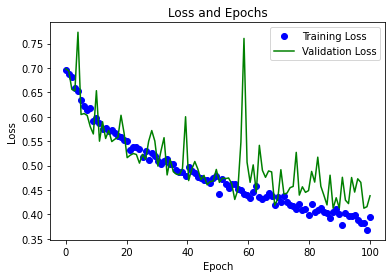

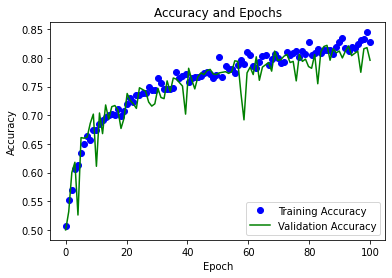

In [34]:
import matplotlib.pylab as plt
import tensorflow as tf

# Saving our model
model2.save('Cats&Dogs')

training_loss = history2.history['loss']
training_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']

epochs = tf.linspace(0,100,100)

plt.plot(epochs,training_loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.title("Loss and Epochs")
plt.legend(loc=1)
plt.show()

plt.plot(epochs,training_acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title("Accuracy and Epochs")
plt.legend(loc=4)
plt.show()

In [32]:
import numpy as np
np.argmax(val_acc)

85

The best validation accuracy is seen after 84 Epochs, and we are able to obtain 82% accuracy.  We may be able to improve our accuracy a few percentage points by fine tuning our hyperparameters, but in order to see a larger improvement, we'll have to either use more data or use a pretrained network.